## make regional (6 NZ regions) time-series of anomalies and terciles + quintiles categories from the CDS models hindcasts (1993 - 2016)

In [1]:
%matplotlib inline

In [2]:
import os
import pathlib

In [3]:
from dateutil.relativedelta import relativedelta

In [4]:
import numpy as np
import pandas as pd

In [5]:
import xarray as xr
import salem

In [6]:
import geopandas as gpd

In [7]:
model = 'ukmo'

In [8]:
var_name = 'PRECIP'

In [9]:
dict_vars = {}
dict_vars['PRECIP'] = 'tprate'
dict_vars['T2M'] = 't2m'

In [10]:
type_var = 'averages'
# type_var = 'anomalies'

In [11]:
if type_var == 'anomalies': 
    dset = salem.open_xr_dataset(f'/home/nicolasf/drives/auck_projects/END19101/Working/data/hindcasts/{model}/{var_name}/{var_name}_hindcasts_1993_2016_{model}_seasonal_anomalies.nc')
else: 
    dset = salem.open_xr_dataset(f'/home/nicolasf/drives/auck_projects/END19101/Working/data/hindcasts/{model}/{var_name}/{var_name}_hindcasts_1993_2016_{model}_seasonal.nc')


In [12]:
dsetm = dset.mean('number')

In [13]:
dsetm = dsetm.sortby('latitude')

In [14]:
dsetm = dsetm.sel(step=3)

In [40]:
dset

<xarray.Dataset>
Dimensions:              (latitude: 180, longitude: 360, number: 28, step: 3, time: 281)
Coordinates:
  * number               (number) int64 0 1 2 3 4 5 6 7 ... 21 22 23 24 25 26 27
  * time                 (time) datetime64[ns] 1993-02-01 ... 2016-12-01
    surface              int64 ...
  * latitude             (latitude) float64 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude            (longitude) float64 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * step                 (step) int64 3 4 5
Data variables:
    tprate               (step, number, time, latitude, longitude) float32 3.6608487e-09 ... 2.4159519e-09
    forecast_valid_time  (time, step) datetime64[ns] ...
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 

In [43]:
dset.forecast_valid_time

<xarray.DataArray 'forecast_valid_time' (time: 281, step: 3)>
array([['1993-05-01T00:00:00.000000000', '1993-06-01T00:00:00.000000000',
        '1993-07-01T00:00:00.000000000'],
       ['1993-06-01T00:00:00.000000000', '1993-07-01T00:00:00.000000000',
        '1993-08-01T00:00:00.000000000'],
       ['1993-07-01T00:00:00.000000000', '1993-08-01T00:00:00.000000000',
        '1993-09-01T00:00:00.000000000'],
       ...,
       ['2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
        '2016-09-01T00:00:00.000000000'],
       ['2017-02-01T00:00:00.000000000', '2017-03-01T00:00:00.000000000',
        '2017-04-01T00:00:00.000000000'],
       ['2017-03-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
        '2017-05-01T00:00:00.000000000']], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
    surface  int64 ...
  * step     (step) int64 3 4 5
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 

In [15]:
shapes  = gpd.read_file('/home/nicolasf/drives/auck_projects/END19101/Working/data/shapefiles/NZ/6regions/NZ_regions/NZ_regions_corrected/NZ_regions_corrected.shp')

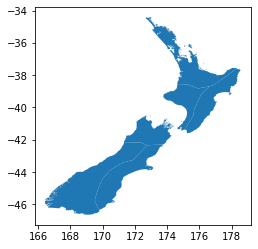

In [16]:
shapes.plot()

In [17]:
shapes

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,(POLYGON ((174.7053010150061 -38.1737677954806...
1,2,2,2,12.336015,2.994028,WNI,(POLYGON ((175.1351580569913 -41.3774534265524...
2,3,3,3,14.235493,3.775388,ENI,(POLYGON ((175.8559460925532 -41.3596964629384...
3,4,4,4,34.656463,3.066280,NSI,(POLYGON ((171.3262002628711 -42.1235461521987...
4,5,5,6,20.191504,4.827228,ESI,(POLYGON ((170.2167454922724 -46.0595478450878...
5,6,6,5,42.941379,9.057410,WSI,"(POLYGON ((169.2074882156066 -46.66370550898, ..."


In [18]:
def make_categories(x, kind='terciles'): 
    def qcut(x, kind='terciles'): 
        clim = x.loc['1993':'2017',:]
        if kind == 'terciles': 
            quantiles = [clim.quantile(q=q).values[0] for q in [0.33333,0.66666]]
            quantiles.insert(0, -np.inf)
            quantiles.append(np.inf)
            return pd.cut(x.values.flatten(), quantiles, labels=[-1,0,1]).to_dense().flatten()
        elif kind == 'quintiles':
            quantiles = [clim.quantile(q=q).values[0] for q in [0.2,0.4,0.6,0.8]]
            quantiles.insert(0, -np.inf)
            quantiles.append(np.inf)
            return pd.cut(x.values.flatten(), quantiles, labels=[-2, -1, 0 , 1, 2]).to_dense().flatten()        
    quantiles_seasons = x.groupby([x.index.month]).apply(qcut, **{'kind':kind})
    dummy = x.values.flatten() * np.nan
    for month in range(1,13): 
        dummy[np.where(x.index.month == month)] = quantiles_seasons[month]
    return dummy

In [20]:
region = 'NNI'

In [21]:
shape = shapes.query("Location == '{}'".format(region))
print(region)
dset_sub = dsetm.salem.subset(shape=shape, margin=1)
dset_sub = dset_sub.salem.roi(shape=shape, all_touched=True)
dset_sub = dset_sub.mean('latitude').mean('longitude')
dset_index = dset_sub.to_dataframe()
time = dset_index.index
time = [x + relativedelta(months=3) for x in time]
dset_index.index = time
dset_index = dset_index.iloc[:,[0]]

NNI


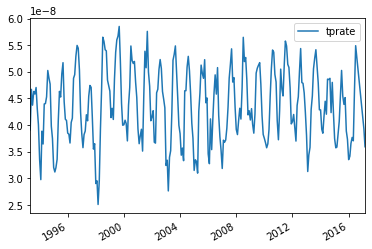

In [22]:
dset_index.plot()

In [24]:
x = dset_index

In [26]:
make_categories(x)

array([-1.,  0., -1., -1., -1., -1.,  0.,  0., -1., -1.,  1., -1.,  1.,
       -1., -1., -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0.,  0.,
       -1., -1.,  0., -1., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -1.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0., -1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  1., -1., -1.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0., -1.,  0.,  1., -1.,
       -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  0., -1.,  0.,  0.,
       -1., -1.,  1.,  0.,  0.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  0.,  0.,  0., -1., -1.,  1.,  0.,  1., -1., -1.,  1., -1.,
        0.,  0., -1., -1.,  0., -1., -1., -1., -1.,  0.,  0.,  0., -1.,
       -1., -1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0

In [27]:
terciles = make_categories(dset_index)

In [29]:
dset_index.loc[:,'terciles'] = terciles

In [30]:
dset_index

,tprate,terciles
1993-05-01,3.911316e-08,-1.0
1993-06-01,4.670749e-08,0.0
1993-07-01,4.374256e-08,-1.0
1993-08-01,4.631469e-08,-1.0
1993-09-01,4.583486e-08,-1.0
...,...,...
2016-05-01,3.705845e-08,-1.0
2016-06-01,4.664571e-08,0.0
2016-07-01,5.490230e-08,1.0
2017-02-01,3.925238e-08,1.0


In [33]:
ess = pd.read_csv('/home/nicolasf/drives/auck_projects/END19101/Working/outputs/ukmo_regional_index_PRECIP_NNI.csv')

In [39]:
(ess.loc[:,'cat3'].values == terciles)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [37]:
terciles

array([-1.,  0., -1., -1., -1., -1.,  0.,  0., -1., -1.,  1., -1.,  1.,
       -1., -1., -1., -1.,  0., -1., -1., -1., -1., -1., -1.,  0.,  0.,
       -1., -1.,  0., -1., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -1.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0., -1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  1., -1., -1.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0., -1.,  0.,  1., -1.,
       -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  0., -1.,  0.,  0.,
       -1., -1.,  1.,  0.,  0.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  0.,  0.,  0., -1., -1.,  1.,  0.,  1., -1., -1.,  1., -1.,
        0.,  0., -1., -1.,  0., -1., -1., -1., -1.,  0.,  0.,  0., -1.,
       -1., -1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0

In [ ]:
def make_categories(x, kind='terciles'): 
    def qcut(x, kind='terciles'): 
        clim = x.loc['1993':'2017',:]
        if kind == 'terciles': 
            quantiles = [clim.quantile(q=q) for q in [0.33333,0.66666]]
            quantiles.insert(0, -np.inf)
            quantiles.append(np.inf)
            return pd.cut(x.values.flatten(), quantiles, labels=[-1,0,1]).to_dense().flatten()
        elif kind == 'quintiles':
            quantiles = [clim.quantile(q=q) for q in [0.2,0.4,0.6,0.8]]
            quantiles.insert(0, -np.inf)
            quantiles.append(np.inf)
            return pd.cut(x.values.flatten(), quantiles, labels=[-2, -1, 0 , 1, 2]).to_dense().flatten()        
    quantiles_seasons = x.groupby([x.index.month]).apply(qcut, **{'kind':kind})
    dummy = x.values.flatten() * np.nan
    for month in range(1,13): 
        dummy[np.where(x.index.month == month)] = quantiles_seasons[month]
    return dummy

In [36]:
make_categories(ess, kind='terciles')

IndexingError: Too many indexers

In [29]:
terciles = make_categories(dset_index, kind='terciles')

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [19]:
for region in shapes.Location.unique(): 
    shape = shapes.query("Location == '{}'".format(region))
    print(region)
    dset_sub = dsetm.salem.subset(shape=shape, margin=1)
    dset_sub = dset_sub.salem.roi(shape=shape, all_touched=True)
    dset_sub = dset_sub.mean('latitude').mean('longitude')
    dset_index = dset_sub.to_dataframe()
    time = dset_index.index
    time = [x + relativedelta(months=3) for x in time]
    dset_index.index = time
    dset_index = dset_index.iloc[:,[0]]
    if type_var == 'anomalies': 
        dset_index.to_csv(f'/home/nicolasf/drives/auck_projects/END19101/Working/outputs/{model}_regional_anomalies_index_{var_name}_{region}.csv')
    else: 
        terciles = make_categories(dset_index, kind='terciles')
        quintiles = make_categories(dset_index, kind='quintiles')
        dset_index.loc[:,'cat3'] = terciles
        dset_index.loc[:,'cat5'] = quintiles
        dset_index.loc[:,'region'] = region
        dset_index.to_csv(f'/home/nicolasf/drives/auck_projects/END19101/Working/outputs/{model}_regional_index_{var_name}_{region}.csv')

NNI
WNI
ENI


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


NSI
ESI


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


WSI


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
region = 'ENI'

In [21]:
shape = shapes.query("Location == '{}'".format(region))
print(region)
dset_sub = dsetm.salem.subset(shape=shape, margin=1)
dset_sub = dset_sub.salem.roi(shape=shape, all_touched=True)

ENI


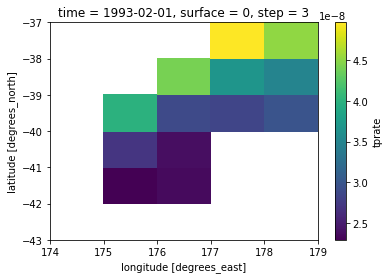

In [25]:
dset_sub['tprate'][0,:,:].plot()

In [26]:
len(dset_index)

281

In [27]:
dset_index

,tprate,cat3,cat5,region
1993-05-01,6.699855e-08,0.0,0.0,WSI
1993-06-01,6.449078e-08,0.0,0.0,WSI
1993-07-01,5.923403e-08,0.0,1.0,WSI
1993-08-01,5.058788e-08,-1.0,-1.0,WSI
1993-09-01,5.728135e-08,0.0,0.0,WSI
1993-10-01,6.860679e-08,0.0,1.0,WSI
1993-11-01,7.899119e-08,1.0,1.0,WSI
1993-12-01,8.157076e-08,1.0,2.0,WSI
1994-01-01,7.436155e-08,1.0,1.0,WSI
1994-02-01,6.651651e-08,0.0,1.0,WSI
